# Iterative Methods for Linear Systems

When solving large linear systems, iterative methods are typically able to produce solutions that converge faster than do direct methods. This notebook provides an overview of the variety of iterative methods that have been developed including discussions of their rates of convergence:

1. Classical methods
    1. Jacobi
    2. Gauss-Seidel
    3. Successive over-relaxation (SOR)
    4. Symmetric successive over-relaxation (SSOR)
    5. Chebyshev

This notebook is an important precursor to the 'Preconditioner Series' which assumes a working knowledge of iterative methods.

Many of the formulas and notations used are from [Matrix Computations by Gene H. Golub and Charles F. Van Loan (4th Ed.)](https://www.amazon.com/Computations-Hopkins-Studies-Mathematical-Sciences/dp/1421407949) and [An Introduction to the Conjugate Gradient Method Without the Agonizing Pain](https://www.cs.cmu.edu/~quake-papers/painless-conjugate-gradient.pdf).

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_triangular
from sklearn.datasets import make_spd_matrix

from plotly import __version__
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import plotly.figure_factory as ff

%matplotlib inline
%load_ext autoreload
%autoreload 2
init_notebook_mode(connected=True)
np.set_printoptions(suppress=True)

## Helper methods

In [50]:
def plot_iters(sol):
    trace = go.Scatter3d(
        x = sol[:, 0],
        y = sol[:, 1],
        z = sol[:, 2],
        marker = dict(
            size=6,
            colorscale='Viridis'),
        line=dict(
            color='black',
            width=3))
    
    return iplot(go.Figure(data=[trace]))

def plot_iters_2d(sol):
    trace = [go.Scatter(
        x = sol[:, 0],
        y = sol[:, 1],
#         marker = dict(
#             size=6,
#             colorscale='Viridis'),
#         line=dict(
#             color='black',
#             width=3))]
    )]
    
    return iplot(go.Figure(data=trace))

## Jacobi method

For a 3-by-3 linear system $Ax=b$,

$$ \begin{bmatrix} a_{11} & a_{12} & a_{13} \\ a_{21} & a_{22} & a_{23} \\
a_{31} & a_{32} & a_{33} \end{bmatrix} \begin{bmatrix} x_1 \\ x_2 \\ x_3
\end{bmatrix} = \begin{bmatrix} b_1 \\ b_2 \\ b_3 \end{bmatrix} $$

the equation can be rearranged to express $x_1$, $x_2$, and $x_3$ in terms of the other variables:

$$ \begin{align} x_1 &= (b_1-a_{12}x_2-a_{13}x_3)/a_{11} \\ x_2 &= (b_2-a_{21}x_1-a_{23}x_3)/a_{22} \\ x_3 &= (b_3-a_{31}x_1-a_{32}x_2)/a_{33} \end{align} $$

All three equations have $x_i$ on both sides of the equal sign, and this can be interpreted as saying that the current approximation of $x_i$, $x_i^{(k-1)}$, is being used to calculate a new approximation of $x_i$, $x_i^{(k)}$. Rewritten the equations from above become:

$$ \begin{align} x_1^{(k)} &= (b_1-a_{12}x_2^{(k-1)}-a_{13}x_3^{(k-1)})/a_{11} \\ x_2^{(k)} &= (b_2-a_{21}x_1^{(k-1)}-a_{23}x_3^{(k-1)})/a_{22} \\ x_3^{(k)} &= (b_3-a_{31}x_1^{(k-1)}-a_{32}x_2^{(k-1)})/a_{33} \end{align} $$

These equations can be written in matrix form using three matrices $D_A$ (main diagonal), $L_A$ (lower triangular), and $U_A$ (upper triangular) such that $A=D_A+L_A+U_A$. Note that $L_A$ and $U_A$ do not include the main diagonal. 

Below is the linear system represented in matrix form:

$$ M_Jx^{(k)}=N_Jx^{(k-1)}+b $$

where $M_J=D_A$ and $N_J=-(L_A+U_A)$.

Rearranging the equation to calculate $x^{(k)}$ yields:

$$ x^{(k)}=M_J^{-1}(N_Jx^{(k-1)}+b) $$

In [3]:
def jacobi(A, x0, b, rtol=1e-5, atol=1e-8, max_iter=1000):
    
    # find inverse of diagonal matrix and off-diagonal matrix
    D_inv, R = np.diag(np.reciprocal(np.diagonal(A).astype(float))), A - np.diag(np.diagonal(A))
    
    i = 0
    x = np.array([x0])
    
    # loop for max_iter iterations or until converged
    while (i < max_iter):
        x = np.vstack((x, D_inv @ (b - R @ x[-1])))
        i += 1
        
        # test convergence
        if (np.allclose(x[-1], x[-2], rtol, atol)):
            print('Iterations:' + str(i))
            return x
        
    # solution did not converge
    print('Maximum number of iterations reached. Did not converge.')

Here, a linear system if defined for which the solution is known: $x=\begin{bmatrix} 1 & 2 & -1 & 1\end{bmatrix}^T$

In [4]:
A = np.array([[10., -1., 2., 0.],
              [-1., 11., -1., 3.],
              [2., -1., 10., -1.],
              [0.0, 3., -1., 8.]])

b = np.array([6., 25., -11., 15.])
x0 = np.ones_like(b)

x = jacobi(A, x0, b); x

Iterations:15


array([[ 1.        ,  1.        ,  1.        ,  1.        ],
       [ 0.5       ,  2.18181818, -1.1       ,  1.625     ],
       [ 1.03818182,  1.775     , -0.81931818,  0.91931818],
       [ 0.94136364,  2.04190083, -1.03820455,  1.10696023],
       [ 1.01183099,  1.96202531, -0.97338662,  0.97951162],
       [ 0.99087986,  2.00908268, -1.00821251,  1.01756718],
       [ 1.00255077,  1.99363326, -0.99551098,  0.99556743],
       [ 0.99846552,  2.00184886, -1.00159009,  1.00294866],
       [ 1.0005029 ,  1.99891177, -0.99921335,  0.99910792],
       [ 0.99973385,  2.00036053, -1.00029861,  1.00050642],
       [ 1.00009578,  1.99981054, -0.99986008,  0.99982748],
       [ 0.99995307,  2.00006848, -1.00005535,  1.00008854],
       [ 1.00001792,  1.99996656, -0.99997491,  0.9999674 ],
       [ 0.99999164,  2.0000128 , -1.00001019,  1.00001568],
       [ 1.00000332,  1.99999404, -0.99999548,  0.99999393],
       [ 0.9999985 ,  2.00000237, -1.00000187,  1.0000028 ]])

In [8]:
plot_iters(x)

In [52]:
A = np.array([[-1., 3.],
              [-1., 11.]])

b = np.array([6., 25.])
x0 = np.ones_like(b)

x = jacobi(A, x0, b); x

Iterations:21


array([[ 1.        ,  1.        ],
       [-3.        ,  2.36363636],
       [ 1.09090909,  2.        ],
       [ 0.        ,  2.37190083],
       [ 1.11570248,  2.27272727],
       [ 0.81818182,  2.37415477],
       [ 1.12246431,  2.34710744],
       [ 1.04132231,  2.37476948],
       [ 1.12430845,  2.36739294],
       [ 1.10217881,  2.37493713],
       [ 1.1248114 ,  2.37292535],
       [ 1.11877604,  2.37498285],
       [ 1.12494856,  2.37443419],
       [ 1.12330256,  2.37499532],
       [ 1.12498597,  2.37484569],
       [ 1.12453706,  2.37499872],
       [ 1.12499617,  2.37495791],
       [ 1.12487374,  2.37499965],
       [ 1.12499896,  2.37498852],
       [ 1.12496557,  2.37499991],
       [ 1.12499972,  2.37499687],
       [ 1.12499061,  2.37499997]])

In [53]:
plot_iters_2d(x)

## Gauss-Seidel method

The Gauss-Seidel method makes a small change to the Jacobi method: it uses the iterate previously calculated to calculate the next iterate. In other words, $x_1^{(k)}$ is plugged into the formula in place of $x_1^{(k-1)}$ to calculate $x_2^{(k)}$. Then, both $x_1^{(k)}$ and $x_2^{(k)}$ are used to calculate $x_3^{(k)}$.

In matrix form, the equations become:

$$ M_{GS}x^{(k)}=N_{GS}x^{(k-1)}+b $$

where $M_{GS}=D_A+L_A$ and $N_{GS}=-U_A$.

Because $M_{GS}$ is a lower triangular matrix, $x^{(k)}$ can be calculated  by forward substitution.

In [10]:
def gauss_seidel(A, x0, b, rtol=1e-5, atol=1e-8, max_iter=10000):
    M, N = np.tril(A), -np.triu(A, 1)
    
    i = 0
    x = np.array([x0])
    
    # loop for max_iter iterations or until converged
    while (i < max_iter):
        x = np.vstack((x, solve_triangular(M, N @ x[-1] + b, lower=True)))
        i += 1
            
        # test convergence
        if (np.allclose(x[-1], x[-2], rtol, atol)):
            print('Iterations:' + str(i))
            return x
        
    # solution did not converge
    print('Maximum number of iterations reached. Did not converge.')

The same linear system of equations is solved.

In [11]:
x = gauss_seidel(A, x0, b); x

Iterations:7


array([[ 1.        ,  1.        ,  1.        ,  1.        ],
       [ 0.5       ,  2.13636364, -0.88636364,  0.96306818],
       [ 0.99090909,  2.01957645, -0.99991736,  0.99266916],
       [ 1.00194112,  2.0021833 , -1.00090298,  0.99906839],
       [ 1.00039893,  2.00020825, -1.00015212,  0.99990289],
       [ 1.00005125,  2.00001731, -1.00001823,  0.99999123],
       [ 1.00000538,  2.00000122, -1.00000183,  0.99999931],
       [ 1.00000049,  2.00000007, -1.00000016,  0.99999996]])

In [12]:
plot_iters(x)

In [48]:
A = np.array([[-1., 3.],
              [-1., 11.]])

b = np.array([6., 25.])
x0 = np.ones_like(b)

x = gauss_seidel(A, x0, b); x

Iterations:12


array([[ 1.        ,  1.        ],
       [-3.        ,  2.        ],
       [-0.        ,  2.27272727],
       [ 0.81818182,  2.34710744],
       [ 1.04132231,  2.36739294],
       [ 1.10217881,  2.37292535],
       [ 1.11877604,  2.37443419],
       [ 1.12330256,  2.37484569],
       [ 1.12453706,  2.37495791],
       [ 1.12487374,  2.37498852],
       [ 1.12496557,  2.37499687],
       [ 1.12499061,  2.37499915],
       [ 1.12499744,  2.37499977]])

In [49]:
plot_iters_2d(x)

## Successive over-relaxation (SOR)

In SSOR, $A$ is split such that $A=M_\omega - N_\omega$ where

$$ M_\omega = \frac{1}{\omega}D_A+L_A \ \ \ \ N_\omega = \bigg(\frac{1}{\omega}-1\bigg)D_A+U_A \ \ \ \ 0 < \omega \leq1$$

The matrix form of the equations is then

$$ \bigg(\frac{1}{\omega}D_A+L_A\bigg)x^{(k)} = \bigg(\bigg(\frac{1}{\omega}-1\bigg)D_A+U_A\bigg)x^{(k-1)}+b $$

For $\omega=1$, the SOR method is simply the Gauss-Seidel method.

In [13]:
def sor(A, x0, b, omega=0.5, rtol=1e-5, atol=1e-8, max_iter=10000):
    M, N = np.diag(np.diag(A)) / omega + np.tril(A, -1), (1 / omega - 1) * np.diag(np.diag(A)) - np.triu(A, 1)
    
    i = 0
    x = np.array([x0])
    
    # loop for max_iter iterations or until converged
    while (i < max_iter):
        x = np.vstack((x, solve_triangular(M, N @ x[-1] + b, lower=True)))
        i += 1
            
        # test convergence
        if (np.allclose(x[-1], x[-2], rtol, atol)):
            return x, i
        
    # solution did not converge
    print('Maximum number of iterations reached. Did not converge.')

Here, the SOR method is run using a range of values for $\omega$.

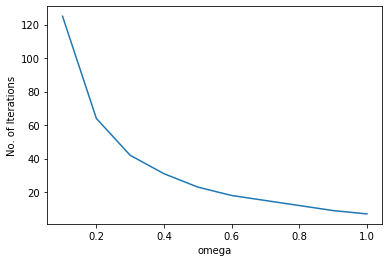

In [14]:
omega = np.arange(0.1, 1.01, 0.1)
iters = []

for o in omega:
    _, i = sor(A, x0, b, o)
    iters = np.append(iters, i)

plt.plot(omega, iters);
plt.xlabel('omega');
plt.ylabel('No. of Iterations');

### Symmetric successive over-relaxation (SSOR)

In the case that $A$ is symmetric, SSOR can be used

In [ ]:
def ssor():

In [ ]:
x = ssor(A, x0, b); x

## Chebyshev method

In [ ]:
def chebyshev():

In [ ]:
x = chebyshev(A, x0, b); x

## Resources

[Matrix Computations by Gene H. Golub and Charles F. Van Loan (4th Ed.)](https://www.amazon.com/Computations-Hopkins-Studies-Mathematical-Sciences/dp/1421407949)

[An Introduction to the Conjugate Gradient Method Without the Agonizing Pain](https://www.cs.cmu.edu/~quake-papers/painless-conjugate-gradient.pdf)